## Introduction

This project aims to build a classification model that predicts wine quality based on its physicochemical properties using machine learning techniques. The dataset used is the Wine Quality dataset from the UCI Machine Learning Repository, which contains measurements like acidity, sugar content, sulfur dioxide levels, pH, and alcohol percentage for various red wine samples.

Originally, the quality attribute is a numeric score ranging from 0 to 10, based on human sensory evaluations. However, since the scores are subjective, imbalanced, and ordered, we transform this into a binary classification task to simplify the modeling process.

Using pandas.cut(), we divide the quality scores into two categories:
- "bad": quality scores from 2 up to and including 6.5
- "good": quality scores above 6.5 up to 8

This transformation allows us to frame the problem as a binary classification task, where we train machine learning models to classify whether a wine is of good quality or not.

The project applies several classification algorithms such as Decision Tree, Logistic Regression, Naive Bayes, and K-Nearest Neighbors (KNN). The performance of these models is evaluated using metrics like accuracy, precision, recall, F1-score, and ROC-AUC, allowing us to understand which physicochemical factors best predict wine quality and which model generalizes well.

# Importing required packages.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
%matplotlib inline

# Loading the dataset

In [2]:
wine = pd.read_csv('winequality-red.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Information on the dataset

In [3]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


# Column distribution

<Axes: xlabel='quality', ylabel='fixed acidity'>

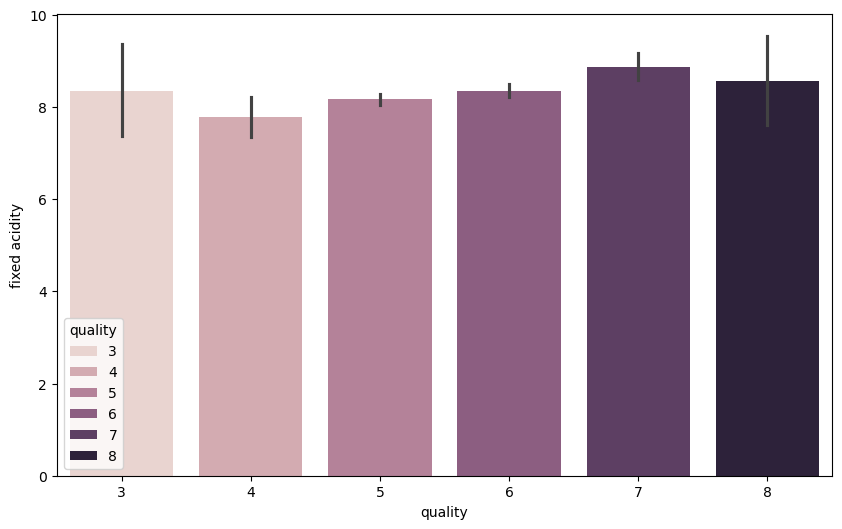

In [4]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', y='fixed acidity', x='quality', data=wine)

<Axes: xlabel='quality', ylabel='citric acid'>

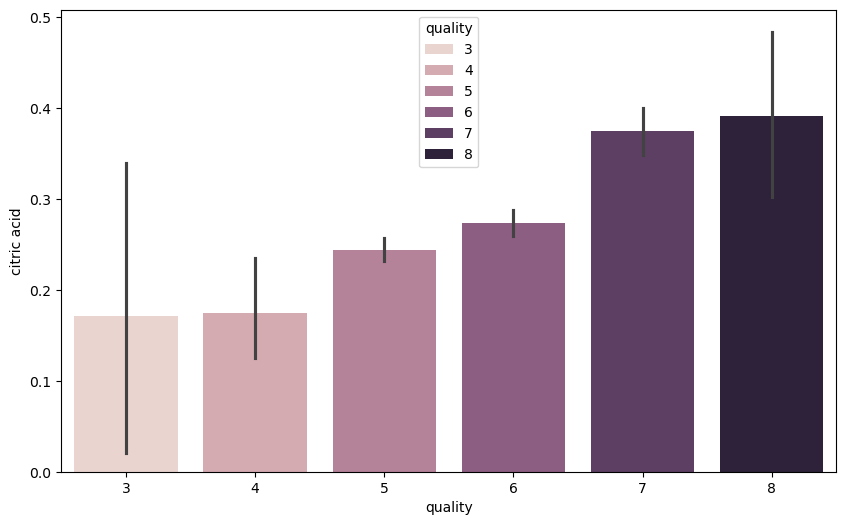

In [5]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'citric acid', data = wine)

<Axes: xlabel='quality', ylabel='residual sugar'>

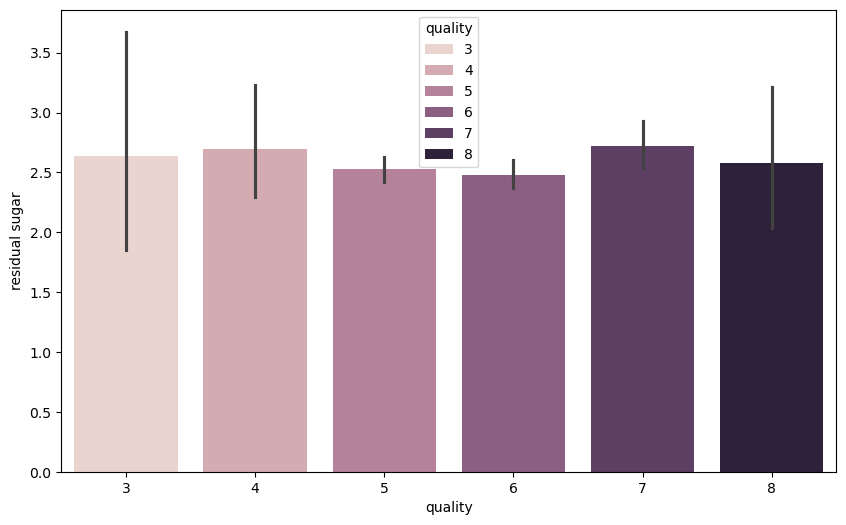

In [6]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'residual sugar', data = wine)

<Axes: xlabel='quality', ylabel='chlorides'>

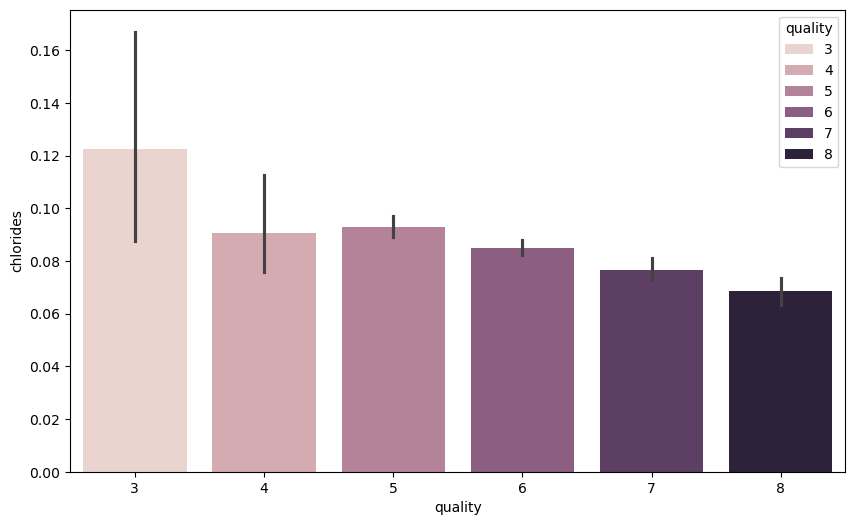

In [7]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'chlorides', data = wine)

<Axes: xlabel='quality', ylabel='free sulfur dioxide'>

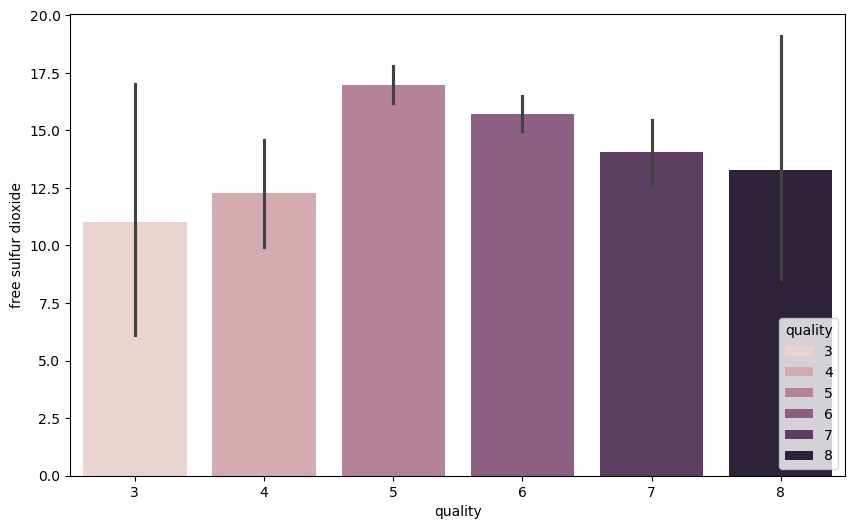

In [8]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'free sulfur dioxide', data = wine)

<Axes: xlabel='quality', ylabel='total sulfur dioxide'>

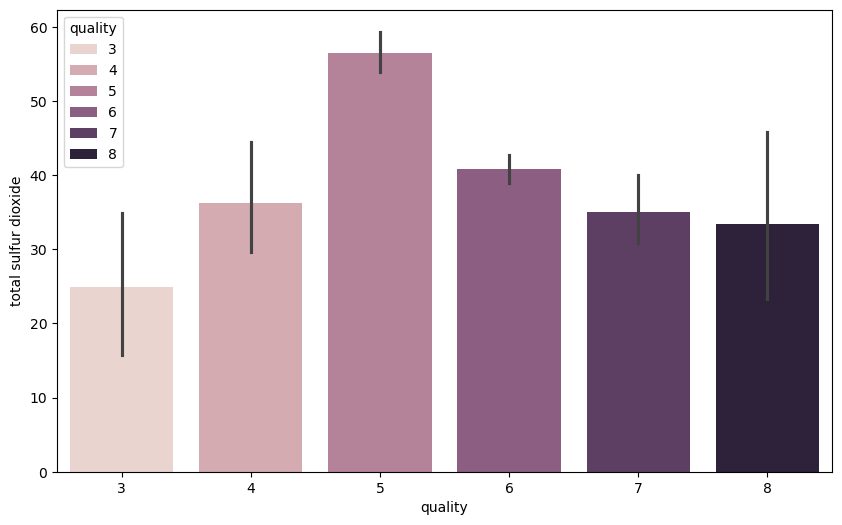

In [9]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'total sulfur dioxide', data = wine)

<Axes: xlabel='quality', ylabel='sulphates'>

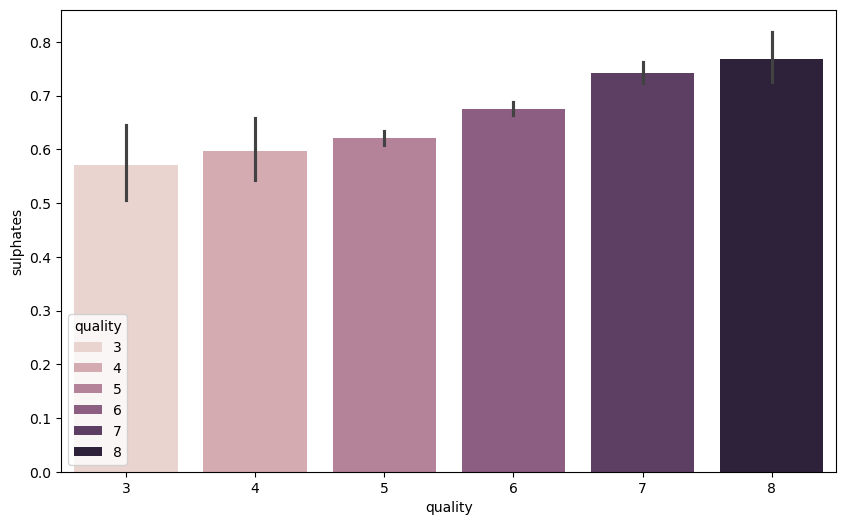

In [10]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'sulphates', data = wine)

<Axes: xlabel='quality', ylabel='alcohol'>

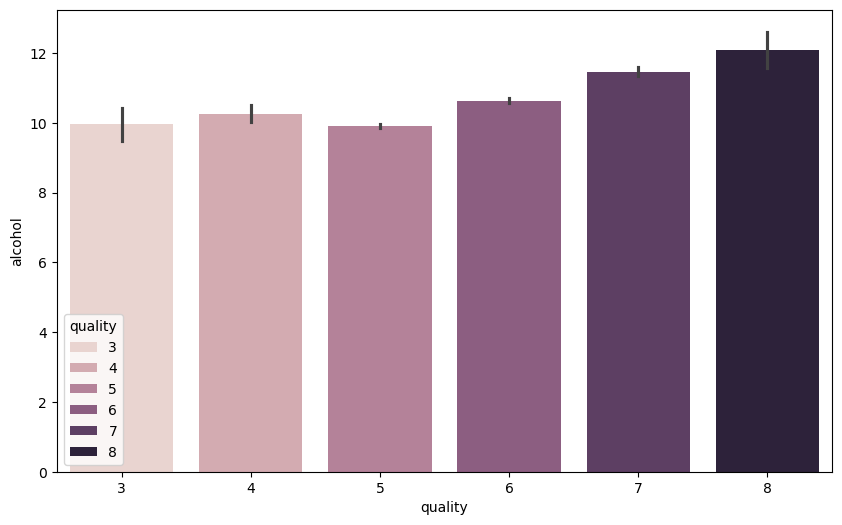

In [11]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'alcohol', data = wine)

# Preprocessing Data

<Axes: xlabel='quality', ylabel='count'>

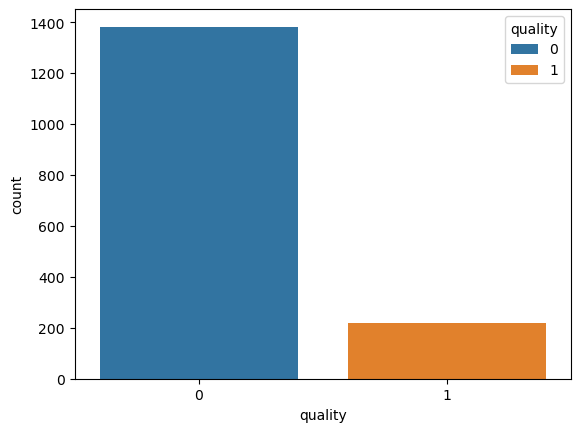

In [12]:
# Define the bin edges:
# quality scores from 2 to 6.5 will be labeled 'bad', and 6.5 to 8 as 'good'
bins = (2, 6.5, 8)

# Define the corresponding labels for the bins
group_names = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)
label_quality = LabelEncoder()

#Bad becomes 0 and good becomes 1 
wine['quality'] = label_quality.fit_transform(wine['quality'])

sns.countplot(hue='quality', x='quality', data=wine)

In [13]:
X = wine.drop('quality', axis = 1)
y = wine['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 

# Random Forest Classifier

In [14]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"🔍 Model: {model.__class__.__name__}")
    print(f"✅ Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"✅ Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"✅ Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"✅ F1-score:  {f1_score(y_test, y_pred):.4f}")
    print("\n🧩 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred))

In [15]:
from sklearn.ensemble import RandomForestClassifier
evaluate_model(RandomForestClassifier(), X_train, y_train, X_test, y_test)

🔍 Model: RandomForestClassifier
✅ Accuracy:  0.8906
✅ Precision: 0.6667
✅ Recall:    0.5106
✅ F1-score:  0.5783

🧩 Confusion Matrix:
[[261  12]
 [ 23  24]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       273
           1       0.67      0.51      0.58        47

    accuracy                           0.89       320
   macro avg       0.79      0.73      0.76       320
weighted avg       0.88      0.89      0.88       320



# Save features and labels

In [16]:
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']